In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error


In [2]:
d_train = pd.read_csv('diamonds_train.csv')
d_test = pd.read_csv('diamonds_test.csv')


In [3]:
for int_col in d_train.select_dtypes('integer').columns:
    d_train[int_col] = pd.to_numeric(d_train[int_col], downcast='integer')

d_train.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
carat      40455 non-null float64
cut        40455 non-null object
color      40455 non-null object
clarity    40455 non-null object
depth      40455 non-null float64
table      40455 non-null float64
price      40455 non-null int16
x          40455 non-null float64
y          40455 non-null float64
z          40455 non-null float64
dtypes: float64(6), int16(1), object(3)
memory usage: 9.2 MB


In [4]:
d_train.describe().T


,count,mean,std,min,25%,50%,75%,max
carat,40455.0,0.797706,0.475544,0.2,0.40,0.70,1.040,4.50
depth,40455.0,61.752841,1.431725,43.0,61.00,61.80,62.500,79.00
table,40455.0,57.446133,2.233535,43.0,56.00,57.00,59.000,95.00
price,40455.0,3928.444469,3992.416147,326.0,945.00,2397.00,5331.000,18823.00
x,40455.0,5.729392,1.124453,0.0,4.71,5.69,6.540,10.23
y,40455.0,5.732819,1.146650,0.0,4.72,5.71,6.540,58.90
z,40455.0,3.537154,0.697062,0.0,2.91,3.52,4.035,8.06


In [5]:
d_train.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [6]:
d_train.shape


(40455, 10)

In [7]:
d_test.shape


(13485, 10)

In [8]:
d_train['cut'].unique()


array(['Premium', 'Very Good', 'Fair', 'Good', 'Ideal'], dtype=object)

In [9]:
d_train['color'].unique()


array(['J', 'H', 'G', 'D', 'F', 'E', 'I'], dtype=object)

In [10]:
d_train['clarity'].unique()


array(['VS2', 'VS1', 'SI1', 'SI2', 'IF', 'VVS1', 'VVS2', 'I1'],
      dtype=object)

['carat']: weight is the most important characteristic in a diamond, the more, the better

['cut']: quality of the cut is (worst) 'Fair', 'Good', 'Very Good', 'Premium', 'Ideal' (best)

['color']: diamond colour is (worst) 'J', 'I', 'H', 'G', 'F', 'E', 'D' (best)

['clarity']: a measurement of how clear the diamond is (worst) 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF' (best)

In [11]:
d_train.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.026528,0.183392,0.921935,0.975688,0.951667,0.967570
depth,0.026528,1.000000,-0.293114,-0.014864,-0.026348,-0.030966,0.094655
table,0.183392,-0.293114,1.000000,0.130111,0.196059,0.184673,0.155189
price,0.921935,-0.014864,0.130111,1.000000,0.885848,0.866163,0.874500
x,0.975688,-0.026348,0.196059,0.885848,1.000000,0.973712,0.984876
y,0.951667,-0.030966,0.184673,0.866163,0.973712,1.000000,0.964828
z,0.967570,0.094655,0.155189,0.874500,0.984876,0.964828,1.000000


In [12]:
d_train.drop(['x', 'y', 'z'], axis = 1, inplace = True)
d_test.drop(['x', 'y', 'z'], axis = 1, inplace = True)

In [13]:
d_train.corr()


,carat,depth,table,price
carat,1.000000,0.026528,0.183392,0.921935
depth,0.026528,1.000000,-0.293114,-0.014864
table,0.183392,-0.293114,1.000000,0.130111
price,0.921935,-0.014864,0.130111,1.000000


In [14]:
print(d_train.isnull().sum())


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64


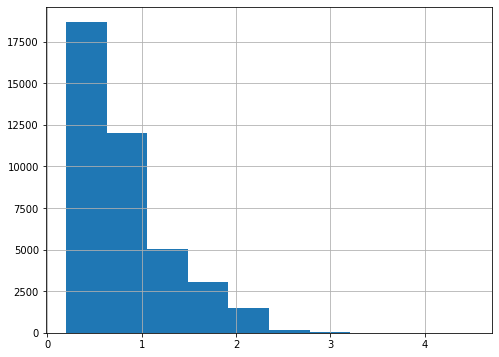

In [15]:
d_train['carat'].hist(figsize=(8,6));


In [16]:
pd.cut(d_train['carat'], 3).value_counts()

(0.196, 1.633]    38124
(1.633, 3.067]     2320
(3.067, 4.5]         11
Name: carat, dtype: int64

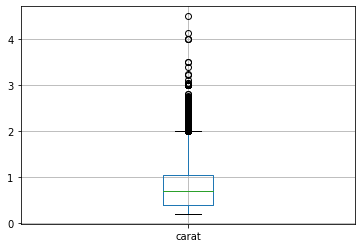

In [17]:
d_train['carat'].plot(kind='box', grid=True);

In [18]:
encoder = OrdinalEncoder(categories = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ['J', 'I', 'H', 'G', 'F', 'E', 'D'], ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
X_encoded = encoder.fit_transform(d_train[['cut', 'color', 'clarity']])
X_encoded_test = encoder.fit_transform(d_test[['cut', 'color', 'clarity']])

In [19]:
d_train.iloc[:,1:4] = X_encoded
d_train.head()


,carat,cut,color,clarity,depth,table,price
0,1.21,3.0,0.0,3.0,62.4,58.0,4268
1,0.32,2.0,2.0,3.0,63.0,57.0,505
2,0.71,0.0,3.0,4.0,65.5,55.0,2686
3,0.41,1.0,6.0,2.0,63.8,56.0,738
4,1.02,4.0,3.0,2.0,60.5,59.0,4882


In [20]:
d_test.iloc[:,2:5] = X_encoded_test
d_test.head()

,id,carat,cut,color,clarity,depth,table
0,0,0.79,2.0,4.0,2.0,62.7,60.0
1,1,1.20,4.0,0.0,4.0,61.0,57.0
2,2,1.57,3.0,2.0,2.0,62.2,61.0
3,3,0.90,2.0,4.0,2.0,63.8,54.0
4,4,0.50,2.0,4.0,4.0,62.9,58.0


In [21]:
scaler = RobustScaler()
d_train_scaled = scaler.fit_transform(d_train.select_dtypes(include='number'))

In [22]:
scaler = RobustScaler()
d_test_scaled = scaler.fit_transform(d_test.select_dtypes(include='number'))

In [23]:
train_validation, test = train_test_split(d_train_scaled, test_size = 0.15, random_state = 29)

In [24]:
train, validation = train_test_split(train_validation, test_size = 0.18, random_state = 29)

In [25]:
print(train.shape, validation.shape, test.shape)

(28196, 7) (6190, 7) (6069, 7)


In [26]:
'''model = DecisionTreeRegressor()
selector = SelectFromModel(model, threshold=0.25)
selector.fit(X_train, y_train)

selector.transform(X_test).shape'''

'model = DecisionTreeRegressor()\nselector = SelectFromModel(model, threshold=0.25)\nselector.fit(X_train, y_train)\n\nselector.transform(X_test).shape'

In [27]:
'''model.fit(X_train, y_train)
model.feature_importances_'''

'model.fit(X_train, y_train)\nmodel.feature_importances_'

In [28]:
'''model = LinearRegression()
model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)'''

'model = LinearRegression()\nmodel.fit(X_train, y_train)\n\npredictions_train = model.predict(X_train)\npredictions_test = model.predict(X_test)'

In [29]:
'''print(f'train error: {mean_squared_error(y_train, predictions_train)}')
print(f'test error: {mean_squared_error(y_test, predictions_test)}')'''

"print(f'train error: {mean_squared_error(y_train, predictions_train)}')\nprint(f'test error: {mean_squared_error(y_test, predictions_test)}')"

In [30]:
'''n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=10, 
                               n_jobs = -1, 
                               scoring='roc_auc')

rf_random.fit(X, y)'''

"n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\nmax_features = ['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 4]\nbootstrap = [True, False]\n\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n\nrf = RandomForestClassifier()\nrf_random = RandomizedSearchCV(estimator = rf, \n                               param_distributions = random_grid, \n                               n_iter = 100, \n                               cv = 3, \n                               verbose=10, \n                               n_jobs = -1, \n                               scoring='roc_auc')\n\nrf_random.fit(X, y)"

In [31]:
'''rf_random.best_estimator_'''

'rf_random.best_estimator_'

In [32]:
'''rf_random.best_score_'''

'rf_random.best_score_'

In [33]:
'''rf_random.best_params_'''

'rf_random.best_params_'

In [34]:
'''rf_random.cv_results_'''

'rf_random.cv_results_'